# Prepare AI Ready Data

Here I prepare the data for AI by reducing to the temporal and spatial scales I'm interested in. Notably, as a part of this project, I expect to experiment with a variety of spatial scales. Accordingly, I've set up this code to be able to easily add a whole bunch of different data subsets. The script will automatically generate a report (at the bottom) describing the shape and dimensions of each subset.

## Import Packages
(and set filepaths)

In [55]:
# set filepath
path_to_cleaned = '../data/cleaned/'

# import packages - general
import numpy as np
import pandas as pd

# import packages - geospatial
import xarray as xr

# import packages - plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

## Read in data

In [56]:
ds_full= xr.open_dataset(path_to_cleaned+'era5.nc')

## Check Units and metadata
Below I confirm all data is well documented and labeled to start with. Fortunetely ECMWF does a pretty good job of this for me

In [57]:
print('Units on SST field of ERA5 data:', ds_full.sst.units)
print('Units on MSLP field of ERA5 data:', ds_full.msl.units)
print('Units on Surface Pressure field of ERA5 data:', ds_full.sp.units)

Units on SST field of ERA5 data: K
Units on MSLP field of ERA5 data: Pa
Units on Surface Pressure field of ERA5 data: Pa


## Downsample data (to speed up computation)

Downsample to 1 degree (from current o.25 degree) to speed computation times. I can always go back to the higher resolution data if needed.

In [58]:
# Downsample from 0.25° to 0.5° resolution (factor of 2)
ds2 = ds_full.coarsen(latitude=2, longitude=2, boundary="trim").mean()

In [59]:
ds = ds2

## Move Data into anomaly space.

This will require removing the seasonal cycle from the monthly data for sst, msl, and sp, and the average at each location for the entire time period.

In [60]:
# set list of variables
vars = ['sst', 'msl', 'sp']


# Calculate the climatology (mean for each month)
print("Calculating Climatology")
climatology = ds.groupby('time.month').mean('time')

# now, remove the climatology from the overall dataset
for v in vars:

    print('Removing Annual Signal for', v)
    ds[v] = ds[v].groupby('time.month') - climatology[v]

# # now, remove the overall average
# for v in vars:
#     # remove the overall mean from the data
#     print("Removing Overall Mean for", v)
#     ds[v] = ds[v] - ds[v].mean('time')


# drop the months variable that we no longer need
ds = ds.drop_vars("month")

Calculating Climatology
Removing Annual Signal for sst
Removing Annual Signal for msl
Removing Annual Signal for sp


## Make sure metadata is still attached

In [61]:
# loop throuh the variables and transfer the units and long names
for v in vars:

    # now tranfer the units over
    ds[v].attrs['units'] = ds_full[v].attrs['units']

    # now transfer the long name over
    ds[v].attrs['long_name'] = ds_full[v].attrs['long_name'] + ' Anomaly'

## Filter for desired time period and spatial region

To start, I'll go with a north pacific reigon and 1970-2023. However, I'll make this flexible, so that I can add additional datasets as I want to expplore in this project



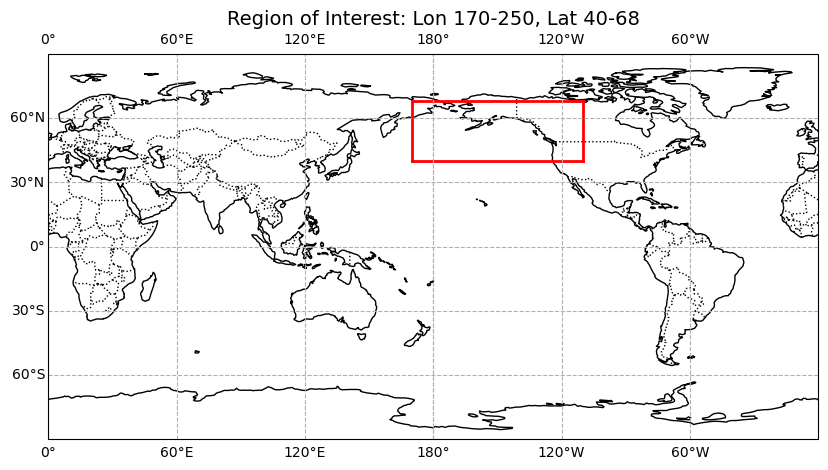

In [62]:
# Set desired reigon and time periods (can list as many as we want)
coords = [[170,250,40,68]]
times = [['1970-01-01','1970-01-01']]

for c in coords:

    fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.set_extent([0, 360, -90, 90], crs=ccrs.PlateCarree())

    # Add a red box for the specified region
    ax.plot([c[0], c[1]], [c[2], c[2]], color='red', linewidth=2, transform=ccrs.PlateCarree())
    ax.plot([c[0], c[1]], [c[3], c[3]], color='red', linewidth=2, transform=ccrs.PlateCarree())
    ax.plot([c[0], c[0]], [c[2], c[3]], color='red', linewidth=2, transform=ccrs.PlateCarree())
    ax.plot([c[1], c[1]], [c[2], c[3]], color='red', linewidth=2, transform=ccrs.PlateCarree())

    # add lat/lon gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--')

    ax.set_title(f'Region of Interest: Lon {c[0]}-{c[1]}, Lat {c[2]}-{c[3]}', fontsize=14)

    plt.show()


## Subset dataset. For each subsetted dataset, clearly report on the dimensions of the dataset, their sshape, and a description of each feature.

Features:
- sst: sea surface temperature (K)
- msl: mean sea level pressure (Pa)
- sp: surface pressure (Pa)

All datasets are saved as anomaly values, with the seasonal cycle and their overall averages subtracted.

In [64]:
# apply the reigon filter to the datasets
variables = ['sst', 'msl', 'sp']

coords = [[180,240,45,65]]
times = [['1970-01-01','2023-12-31']]  # Ensure the time range is valid

for c in coords:
    for t in times:
        ds_subset = xr.Dataset()
        for v in variables:
            ds_subset[v] = ds[v].sel(latitude=slice(c[3], c[2]), longitude=slice(c[0], c[1]), time=slice(t[0], t[1]))

        # set filename
        filename = f"era5_subset_{c[0]}-{c[1]}_{c[2]}-{c[3]}_{t[0][:4]}-{t[1][:4]}.nc"

        # delete the file if it already exists
        try:
            os.remove('../data/ai_ready/'+filename)
        except:
            pass
        
        #save file
        ds_subset.to_netcdf('../data/ai_ready/'+filename)
      
        # Print a report of the subsetted dataset
        print(f"Subsetted dataset saved to {filename}")
        print("    The subsetted dataset has the following dimensions:")
        print("        - Time:", ds_subset.time.shape, 
              "from", ds_subset.time.values[0],
                "to", ds_subset.time.values[-1],
                  "with a resolution of one month")
        print("        - Latitude:", ds_subset.latitude.shape,
               "from", ds_subset.latitude.values[0],
                 "to", ds_subset.latitude.values[-1], "degrees N "
                 "with a resolution of", ds_subset.latitude.diff('latitude').values[0],"degrees")
        print("        - Longitude:", ds_subset.longitude.shape,"from", ds_subset.longitude.values[0],
               "to", ds_subset.longitude.values[-1],"degrees E",
                 "with a resolution of", ds_subset.longitude.diff('longitude').values[0])
        print("    The subsetted dataset has the following variables and shapes:")
        for v in variables:
            print(f"        - {v}: {ds_subset[v].shape}, {ds_subset[v].units}")
        print("    The subsetted dataset has the following total number of data points (SST lower due to land masking):")
        for v in variables:
            print(f"        - {v}: {np.count_nonzero(~np.isnan(ds_subset[v].values))}")

Subsetted dataset saved to era5_subset_180-240_45-65_1970-2023.nc
    The subsetted dataset has the following dimensions:
        - Time: (648,) from 1970-01-01T00:00:00.000000000 to 2023-12-01T00:00:00.000000000 with a resolution of one month
        - Latitude: (40,) from 64.875 to 45.375 degrees N with a resolution of -0.5 degrees
        - Longitude: (120,) from 180.125 to 239.625 degrees E with a resolution of 0.5
    The subsetted dataset has the following variables and shapes:
        - sst: (648, 40, 120), K
        - msl: (648, 40, 120), Pa
        - sp: (648, 40, 120), Pa
    The subsetted dataset has the following total number of data points (SST lower due to land masking):
        - sst: 2166264
        - msl: 3110400
        - sp: 3110400
